<a href="https://colab.research.google.com/github/IhsanKT/Rice-type-classification/blob/main/rice_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initializations and Dataset Download

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: IHSAN KT
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 882MB/s]

#Imports

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#Dataset

In [3]:
data_df  = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
data_df.shape

(18185, 11)

In [5]:
data_df['Class'].unique()

array([1, 0])

In [6]:
data_df['Class'].value_counts()

,count
Class,
1,9985
0,8200


#Data preprocessing

In [7]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


#Data splitting

In [8]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


#Dataset object

In [12]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [13]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

#Data Loaders

In [14]:
train_dataloader = DataLoader(training_data, batch_size = 8, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 8, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 8, shuffle = True)

In [15]:
for x,y in train_dataloader:
  print(x)
  print('=========')
  print(y)
  break

tensor([[0.6191, 0.8119, 0.6692, 0.9604, 0.5861, 0.7868, 0.6458, 0.6631, 0.7722,
         0.6883],
        [0.5740, 0.8595, 0.5833, 0.9848, 0.5461, 0.7577, 0.5748, 0.6765, 0.6880,
         0.8359],
        [0.9685, 0.9039, 0.9322, 0.9159, 0.9212, 0.9841, 0.7015, 0.7788, 0.8756,
         0.5502],
        [0.8310, 0.8233, 0.8781, 0.9071, 0.7941, 0.9116, 0.7833, 0.7217, 0.8750,
         0.5319],
        [0.5822, 0.7660, 0.6713, 0.9503, 0.5548, 0.7630, 0.6338, 0.6409, 0.7772,
         0.6474],
        [0.6068, 0.8534, 0.6235, 0.9767, 0.5775, 0.7789, 0.5193, 0.6871, 0.7049,
         0.7765],
        [0.7962, 0.8646, 0.8021, 0.9397, 0.7533, 0.8923, 0.9125, 0.7266, 0.8271,
         0.6115],
        [0.8063, 0.9035, 0.7728, 0.9544, 0.7652, 0.8979, 0.5970, 0.7529, 0.7800,
         0.6632]], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 0., 0.], device='cuda:0')


#Model class

In [16]:
HIDDEN_NEURONS = 10
class Mymodel(nn.Module):
  def __init__(self):
    super(Mymodel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = Mymodel().to(device)

In [17]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#Loss & Optimizer

In [18]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

#Training

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs =10
for epoch in range(epochs):
  total_acc_train = 0
  total_acc_validation = 0
  total_loss_train = 0
  total_loss_validation = 0

  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_validation += acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4))
  print(f'Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000,4)} Train Accuracy: {round(total_acc_train/training_data.__len__()*100,4) } Validation Loss: {round(total_loss_validation/1000,4)} Validation Accuracy: {round(total_acc_validation/validation_data.__len__()*100,4) }')
  print('='*25)

Epoch no. 1 Train Loss: 0.6812 Train Accuracy: 89.2058 Validation Loss: 0.0512 Validation Accuracy: 98.5337
Epoch no. 2 Train Loss: 0.1409 Train Accuracy: 98.4681 Validation Loss: 0.0231 Validation Accuracy: 98.607
Epoch no. 3 Train Loss: 0.0842 Train Accuracy: 98.5938 Validation Loss: 0.0185 Validation Accuracy: 98.5337
Epoch no. 4 Train Loss: 0.0715 Train Accuracy: 98.6409 Validation Loss: 0.0178 Validation Accuracy: 98.4971
Epoch no. 5 Train Loss: 0.0667 Train Accuracy: 98.633 Validation Loss: 0.0166 Validation Accuracy: 98.4238
Epoch no. 6 Train Loss: 0.0647 Train Accuracy: 98.688 Validation Loss: 0.0197 Validation Accuracy: 98.2038
Epoch no. 7 Train Loss: 0.0647 Train Accuracy: 98.6016 Validation Loss: 0.0181 Validation Accuracy: 98.4971
Epoch no. 8 Train Loss: 0.0645 Train Accuracy: 98.6252 Validation Loss: 0.0164 Validation Accuracy: 98.607
Epoch no. 9 Train Loss: 0.0636 Train Accuracy: 98.6488 Validation Loss: 0.0196 Validation Accuracy: 98.2771
Epoch no. 10 Train Loss: 0.0648 

#Testing

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc
print('Accuracy:', round(total_acc_test/testing_data.__len__()*100,4))


Accuracy: 98.5337


#Plotting

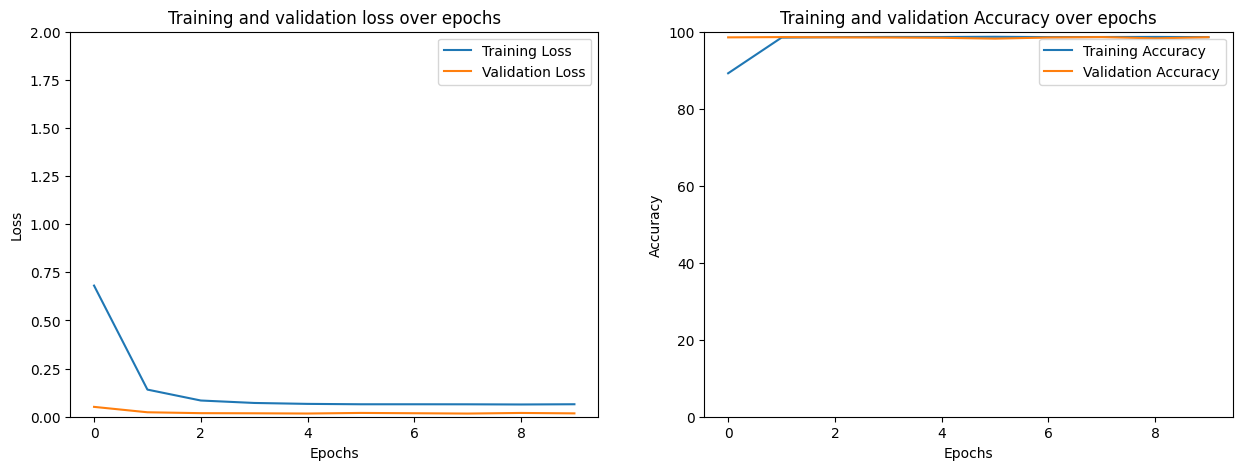

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and validation loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

#Inference

In [24]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 4537
Major Axis Length: 92
Minor Axis Length: 64
Eccentricity: 0.71
Convex Area: 4677
EquivDiameter: 76
Extent: 0.65
Perimeter: 273
Roundness: 0.76
AspectRation: 0.36
tensor([3.7764e-06], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
